## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5,0.7]
redice_lr_patient = [3,4,5]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr =ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0728 21:46:37.131883 29684 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3


W0728 21:46:37.513964 29684 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 21:46:37.525932 29684 deprecation_wrapper.py:119] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0728 21:46:37.625665 29684 deprecation.py:323] From C:\Users\a2279\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 6s 123us/step - loss: 1.7224 - acc: 0.4028 - val_loss: 1.8157 - val_acc: 0.3710
Epoch 13/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.7036 - acc: 0.4089 - val_loss: 1.8020 - val_acc: 0.3758
Epoch 14/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.6865 - acc: 0.4138 - val_loss: 1.7900 - val_acc: 0.3767
Epoch 15/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.6700 - acc: 0.4201 - val_loss: 1.7764 - val_acc: 0.3828
Epoch 16/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.6546 - acc: 0.4254 - val_loss: 1.7673 - val_acc: 0.3853
Epoch 17/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.6411 - acc: 0.4313 - val_loss: 1.7560 - val_acc: 0.3896
Epoch 18/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.6284 - acc: 0.4343 - val_loss: 1.7464 - val_acc: 0.3939
Epoch 19/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 161us/step - loss: 2.7187 - acc: 0.1522 - val_loss: 2.5199 - val_acc: 0.2110
Epoch 2/25
50000/50000 [==============================] - 7s 130us/step - loss: 2.2718 - acc: 0.2483 - val_loss: 2.2370 - val_acc: 0.2643
Epoch 3/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.1039 - acc: 0.2885 - val_loss: 2.1006 - val_acc: 0.2959
Epoch 4/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.0057 - acc: 0.3139 - val_loss: 2.0159 - val_acc: 0.3193
Epoch 5/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.9396 - acc: 0.3305 - val_loss: 1.9630 - val_acc: 0.3359
Epoch 6/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.8887 - acc: 0.3460 - val_loss: 1.9205 - val_acc: 0.3478
Epoch 7/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.8484 - acc: 0.3592 - val_loss: 1.8874 - 

Epoch 24/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5673 - acc: 0.4556 - val_loss: 1.6886 - val_acc: 0.4125
Epoch 25/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.5581 - acc: 0.4595 - val_loss: 1.6827 - val_acc: 0.4129
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batc

50000/50000 [==============================] - 8s 154us/step - loss: 1.7383 - acc: 0.3977 - val_loss: 1.8171 - val_acc: 0.3704
Epoch 12/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.7195 - acc: 0.4044 - val_loss: 1.8035 - val_acc: 0.3730
Epoch 13/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.7028 - acc: 0.4091 - val_loss: 1.7887 - val_acc: 0.3785
Epoch 14/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.6866 - acc: 0.4143 - val_loss: 1.7762 - val_acc: 0.3806
Epoch 15/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.6699 - acc: 0.4208 - val_loss: 1.7639 - val_acc: 0.3849
Epoch 16/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.6568 - acc: 0.4263 - val_loss: 1.7520 - val_acc: 0.3921
Epoch 17/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.6431 - acc: 0.4297 - val_loss: 1.7423 - val_acc: 0.3947
Epoch 18/25
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 195us/step - loss: 2.5951 - acc: 0.1779 - val_loss: 2.5593 - val_acc: 0.2237
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 2.2171 - acc: 0.2657 - val_loss: 2.2276 - val_acc: 0.2726
Epoch 3/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.0595 - acc: 0.3043 - val_loss: 2.0942 - val_acc: 0.2963
Epoch 4/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.9702 - acc: 0.3276 - val_loss: 2.0156 - val_acc: 0.3185
Epoch 5/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.9074 - acc: 0.3449 - val_loss: 1.9594 - val_acc: 0.3335
Epoch 6/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.8597 - acc: 0.3578 - val_loss: 1.9165 - val_acc: 0.3408
Epoch 7/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.8210 - acc: 0.3697 - val_loss: 1.8833 -

50000/50000 [==============================] - 8s 153us/step - loss: 0.5930 - acc: 0.8196 - val_loss: 1.3799 - val_acc: 0.5353
Epoch 23/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.5872 - acc: 0.8218 - val_loss: 1.3857 - val_acc: 0.5358

Epoch 00023: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 24/25
50000/50000 [==============================] - 8s 160us/step - loss: 0.5792 - acc: 0.8260 - val_loss: 1.3797 - val_acc: 0.5380
Epoch 25/25
50000/50000 [==============================] - 8s 164us/step - loss: 0.5763 - acc: 0.8281 - val_loss: 1.3838 - val_acc: 0.5396
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)            

Epoch 9/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.5155 - acc: 0.4740 - val_loss: 1.6400 - val_acc: 0.4277
Epoch 10/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.4942 - acc: 0.4823 - val_loss: 1.6259 - val_acc: 0.4325
Epoch 11/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.4785 - acc: 0.4886 - val_loss: 1.6180 - val_acc: 0.4352
Epoch 12/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.4622 - acc: 0.4938 - val_loss: 1.6096 - val_acc: 0.4384
Epoch 13/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.4467 - acc: 0.4985 - val_loss: 1.5981 - val_acc: 0.4382
Epoch 14/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.4331 - acc: 0.5042 - val_loss: 1.5920 - val_acc: 0.4434
Epoch 15/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.4180 - acc: 0.5095 - val_loss: 1.5848 - val_acc: 0.4472
Epoch 16/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 239us/step - loss: 2.1882 - acc: 0.2739 - val_loss: 2.0381 - val_acc: 0.3187
Epoch 2/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.7962 - acc: 0.3779 - val_loss: 1.8549 - val_acc: 0.3578
Epoch 3/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.7004 - acc: 0.4060 - val_loss: 1.7785 - val_acc: 0.3821
Epoch 4/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.6451 - acc: 0.4259 - val_loss: 1.7221 - val_acc: 0.3976
Epoch 5/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.6016 - acc: 0.4418 - val_loss: 1.6905 - val_acc: 0.4099
Epoch 6/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.5703 - acc: 0.4527 - val_loss: 1.6656 - val_acc: 0.4112
Epoch 7/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.5428 - acc: 0.4633 - val_loss: 1.6434 -

Epoch 24/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.3118 - acc: 0.5482 - val_loss: 1.5542 - val_acc: 0.4538
Epoch 25/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.3040 - acc: 0.5512 - val_loss: 1.5487 - val_acc: 0.4563
Numbers of exp: 15, reduce_factor: 0.70, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 9s 180us/step - loss: 1.4803 - acc: 0.4879 - val_loss: 1.6230 - val_acc: 0.4408
Epoch 12/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.4642 - acc: 0.4937 - val_loss: 1.6186 - val_acc: 0.4409
Epoch 13/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.4498 - acc: 0.5000 - val_loss: 1.6069 - val_acc: 0.4453
Epoch 14/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.4356 - acc: 0.5031 - val_loss: 1.6006 - val_acc: 0.4443
Epoch 15/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.4226 - acc: 0.5091 - val_loss: 1.5992 - val_acc: 0.4485
Epoch 16/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.4096 - acc: 0.5136 - val_loss: 1.5896 - val_acc: 0.4527
Epoch 17/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.3975 - acc: 0.5177 - val_loss: 1.5850 - val_acc: 0.4550
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 267us/step - loss: 1.8093 - acc: 0.3686 - val_loss: 2.4762 - val_acc: 0.2806
Epoch 2/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.5424 - acc: 0.4574 - val_loss: 2.1116 - val_acc: 0.3059
Epoch 3/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.4343 - acc: 0.4920 - val_loss: 2.3824 - val_acc: 0.2745
Epoch 4/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3565 - acc: 0.5194 - val_loss: 2.1735 - val_acc: 0.2960
Epoch 5/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.3022 - acc: 0.5397 - val_loss: 2.0844 - val_acc: 0.3143
Epoch 6/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.2460 - acc: 0.5597 - val_loss: 3.1955 - val_acc: 0.2087
Epoch 7/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.1988 - acc: 0.5761 - val_loss: 2.0484 -

50000/50000 [==============================] - 8s 164us/step - loss: 0.9297 - acc: 0.6961 - val_loss: 1.4253 - val_acc: 0.5042
Epoch 22/25
50000/50000 [==============================] - 8s 162us/step - loss: 0.9255 - acc: 0.6999 - val_loss: 1.4233 - val_acc: 0.5082

Epoch 00022: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 23/25
50000/50000 [==============================] - 8s 162us/step - loss: 0.9172 - acc: 0.7025 - val_loss: 1.4231 - val_acc: 0.5065
Epoch 24/25
50000/50000 [==============================] - 9s 180us/step - loss: 0.9162 - acc: 0.7033 - val_loss: 1.4234 - val_acc: 0.5056
Epoch 25/25
50000/50000 [==============================] - 9s 177us/step - loss: 0.9149 - acc: 0.7034 - val_loss: 1.4228 - val_acc: 0.5058
Numbers of exp: 20, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)    

Epoch 8/25
50000/50000 [==============================] - 9s 186us/step - loss: 2.1279 - acc: 0.2877 - val_loss: 2.1634 - val_acc: 0.2865
Epoch 9/25
50000/50000 [==============================] - 9s 173us/step - loss: 2.0838 - acc: 0.2980 - val_loss: 2.1242 - val_acc: 0.2950
Epoch 10/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.0464 - acc: 0.3096 - val_loss: 2.0909 - val_acc: 0.3037
Epoch 11/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.0131 - acc: 0.3190 - val_loss: 2.0612 - val_acc: 0.3152
Epoch 12/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.9838 - acc: 0.3275 - val_loss: 2.0346 - val_acc: 0.3243
Epoch 13/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.9568 - acc: 0.3352 - val_loss: 2.0097 - val_acc: 0.3297
Epoch 14/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.9324 - acc: 0.3421 - val_loss: 1.9908 - val_acc: 0.3361
Epoch 15/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 250us/step - loss: 2.8565 - acc: 0.1369 - val_loss: 2.7228 - val_acc: 0.1725
Epoch 2/25
50000/50000 [==============================] - 8s 152us/step - loss: 2.6348 - acc: 0.1801 - val_loss: 2.5868 - val_acc: 0.2014
Epoch 3/25
50000/50000 [==============================] - 8s 153us/step - loss: 2.4915 - acc: 0.2090 - val_loss: 2.4792 - val_acc: 0.2201
Epoch 4/25
50000/50000 [==============================] - 7s 149us/step - loss: 2.3845 - acc: 0.2309 - val_loss: 2.3933 - val_acc: 0.2398
Epoch 5/25
50000/50000 [==============================] - 8s 153us/step - loss: 2.3029 - acc: 0.2463 - val_loss: 2.3252 - val_acc: 0.2534
Epoch 6/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.2372 - acc: 0.2632 - val_loss: 2.2666 - val_acc: 0.2689
Epoch 7/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.1835 - acc: 0.2750 - val_loss: 2.2194 -

Epoch 24/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.7747 - acc: 0.3853 - val_loss: 1.8458 - val_acc: 0.3661
Epoch 25/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.7629 - acc: 0.3882 - val_loss: 1.8377 - val_acc: 0.3680
Numbers of exp: 25, reduce_factor: 0.70, reduce_patient: 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 8s 166us/step - loss: 2.0267 - acc: 0.3163 - val_loss: 2.0634 - val_acc: 0.3083
Epoch 12/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.9993 - acc: 0.3228 - val_loss: 2.0361 - val_acc: 0.3146
Epoch 13/25
50000/50000 [==============================] - 10s 201us/step - loss: 1.9736 - acc: 0.3306 - val_loss: 2.0119 - val_acc: 0.3189
Epoch 14/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.9493 - acc: 0.3366 - val_loss: 1.9910 - val_acc: 0.3237
Epoch 15/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.9267 - acc: 0.3428 - val_loss: 1.9727 - val_acc: 0.3282
Epoch 16/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.9067 - acc: 0.3485 - val_loss: 1.9557 - val_acc: 0.3331
Epoch 17/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.8886 - acc: 0.3526 - val_loss: 1.9408 - val_acc: 0.3380
Epoch 18/25
50000/50000 [=============

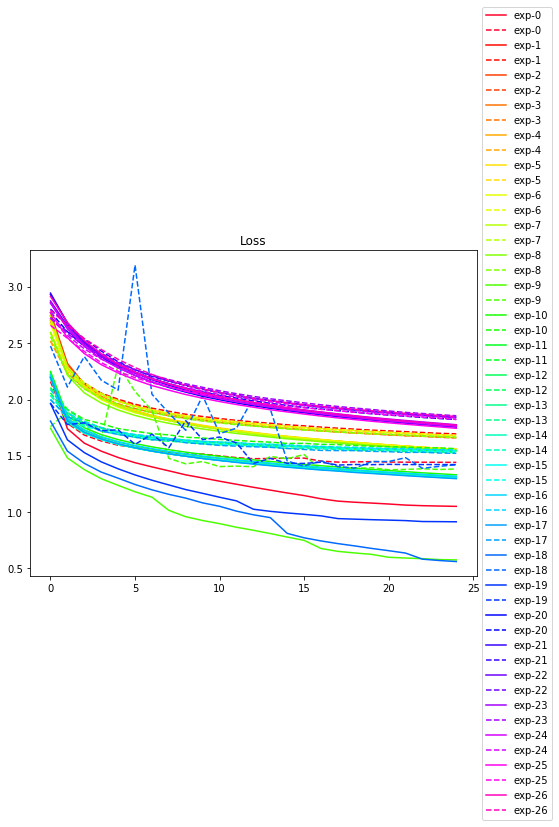

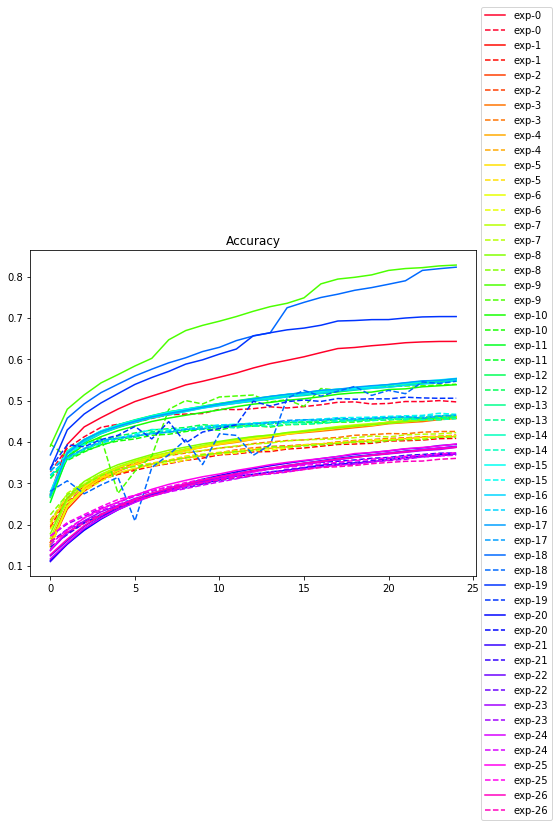

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()